In [80]:
# %load jupyter_default.py
import pandas as pd
import numpy as np
import os
import sys
import re
import datetime
import time
import glob
import json
from tqdm import tqdm, tqdm_notebook
from colorama import Fore, Style

from dotenv import load_dotenv
load_dotenv('../../.env')

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.style.use('ggplot')
# plt.style.use('fivethirtyeight')

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['legend.fancybox'] = True
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['xtick.major.pad'] = 15
plt.rcParams['xtick.minor.pad'] = 15
plt.rcParams['ytick.major.pad'] = 10
plt.rcParams['ytick.minor.pad'] = 10

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)


def savefig(name, path='../../results/figures'):
    f_path = os.path.join(path, f'{name}.png')
    print('Saving figure to file: {}'.format(f_path))
    plt.savefig(f_path, bbox_inches='tight', dpi=300)

%reload_ext autoreload
%autoreload 2
    
%reload_ext version_information
%version_information pandas, numpy

from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;padding-top:50px;padding-bottom:50px}</style>')

How do we avoid going bust? Can we use frequentist statistics to determine good bet sizing?

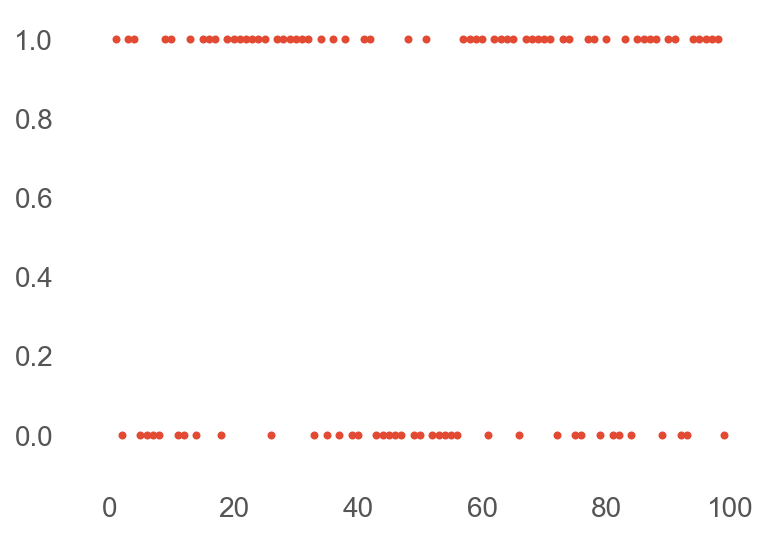

In [17]:
x = np.arange(1, 100, 1)
y = np.random.binomial(n=1, p=0.5, size=len(x))

plt.plot(
    x, y, '.'
)

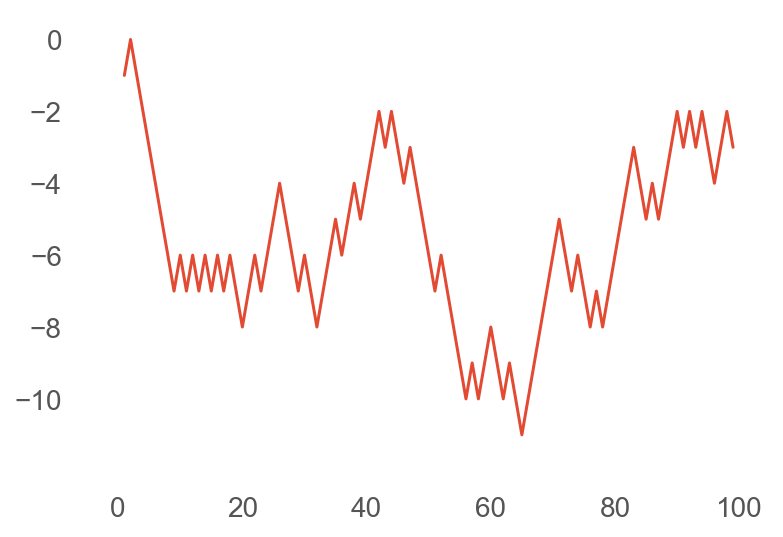

In [21]:
np.random.seed(1)

x = np.arange(1, 100, 1)
y = np.random.binomial(n=1, p=0.5, size=len(x))
y = [yi if yi == 1 else -1 for yi in y]

plt.plot(
    x, np.cumsum(y), 
)

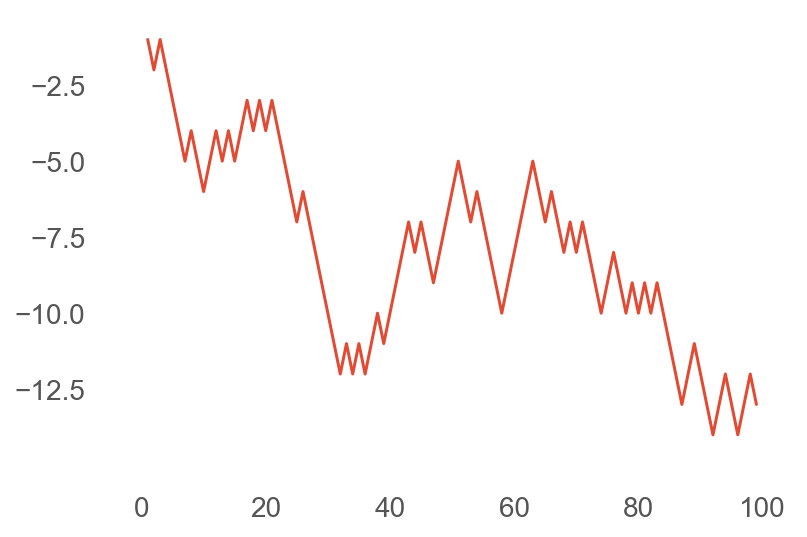

In [22]:
np.random.seed(2)

x = np.arange(1, 100, 1)
y = np.random.binomial(n=1, p=0.5, size=len(x))
y = [yi if yi == 1 else -1 for yi in y]

plt.plot(
    x, np.cumsum(y), 
)

In [33]:
x

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

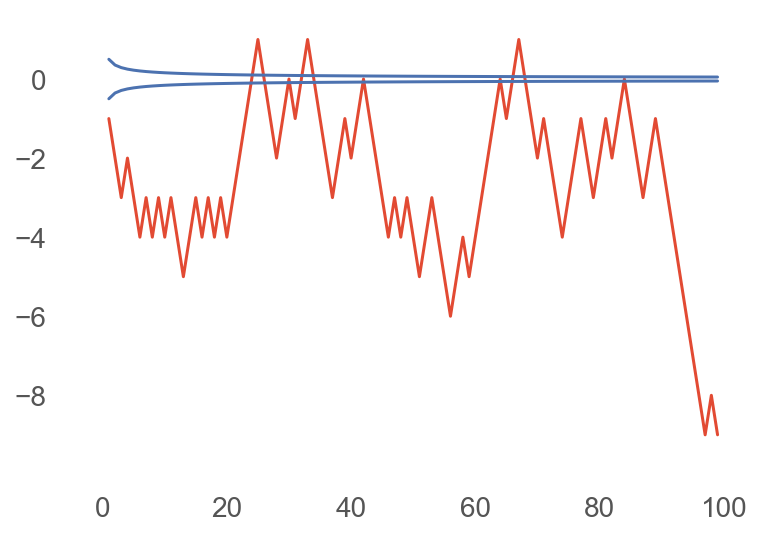

In [35]:
p = 0.5
n = 100

x = np.arange(1, n, 1)
y = np.random.binomial(n=1, p=p, size=len(x))
y = [yi if yi == 1 else -1 for yi in y]

bernoulli_std = lambda n: np.sqrt(p*(1-p)/n)
y_std = np.array([bernoulli_std(xi) for xi in x])

plt.plot(
    x, np.cumsum(y), 
)

plt.plot(
    x, y_std, c='b'
)
plt.plot(
    x, -y_std, c='b'
)

This is not going as expected.. so I'll use monte carlo

In [37]:
np.random.binomial?

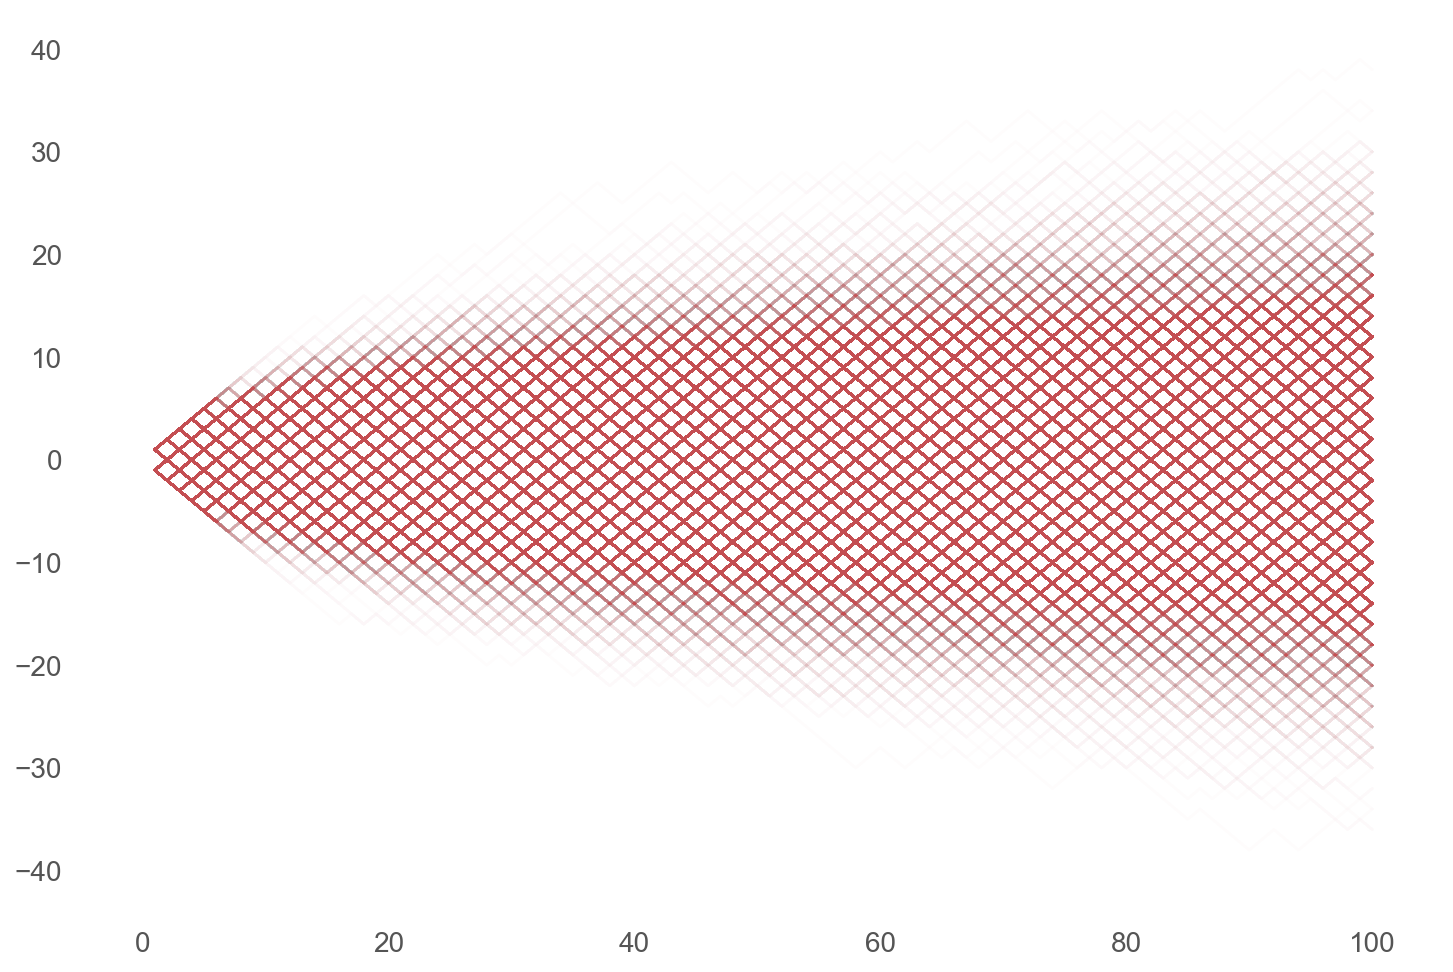

In [86]:
p = 0.5
n_bets = 100
n_walkers = 10000

x = np.arange(1, n_bets+1, 1)

y = np.random.binomial(n=1, p=p, size=(n_walkers, n_bets))
y[y == 0] = -1
balances = np.cumsum(y, axis=1)

for balance in tqdm_notebook(balances):
    plt.plot(
        x, balance, color='r', alpha=np.sqrt(1/n_walkers),
    )

Text(0.5, 0.98, 'Monte carlo (p=0.5, 50 walkers)')

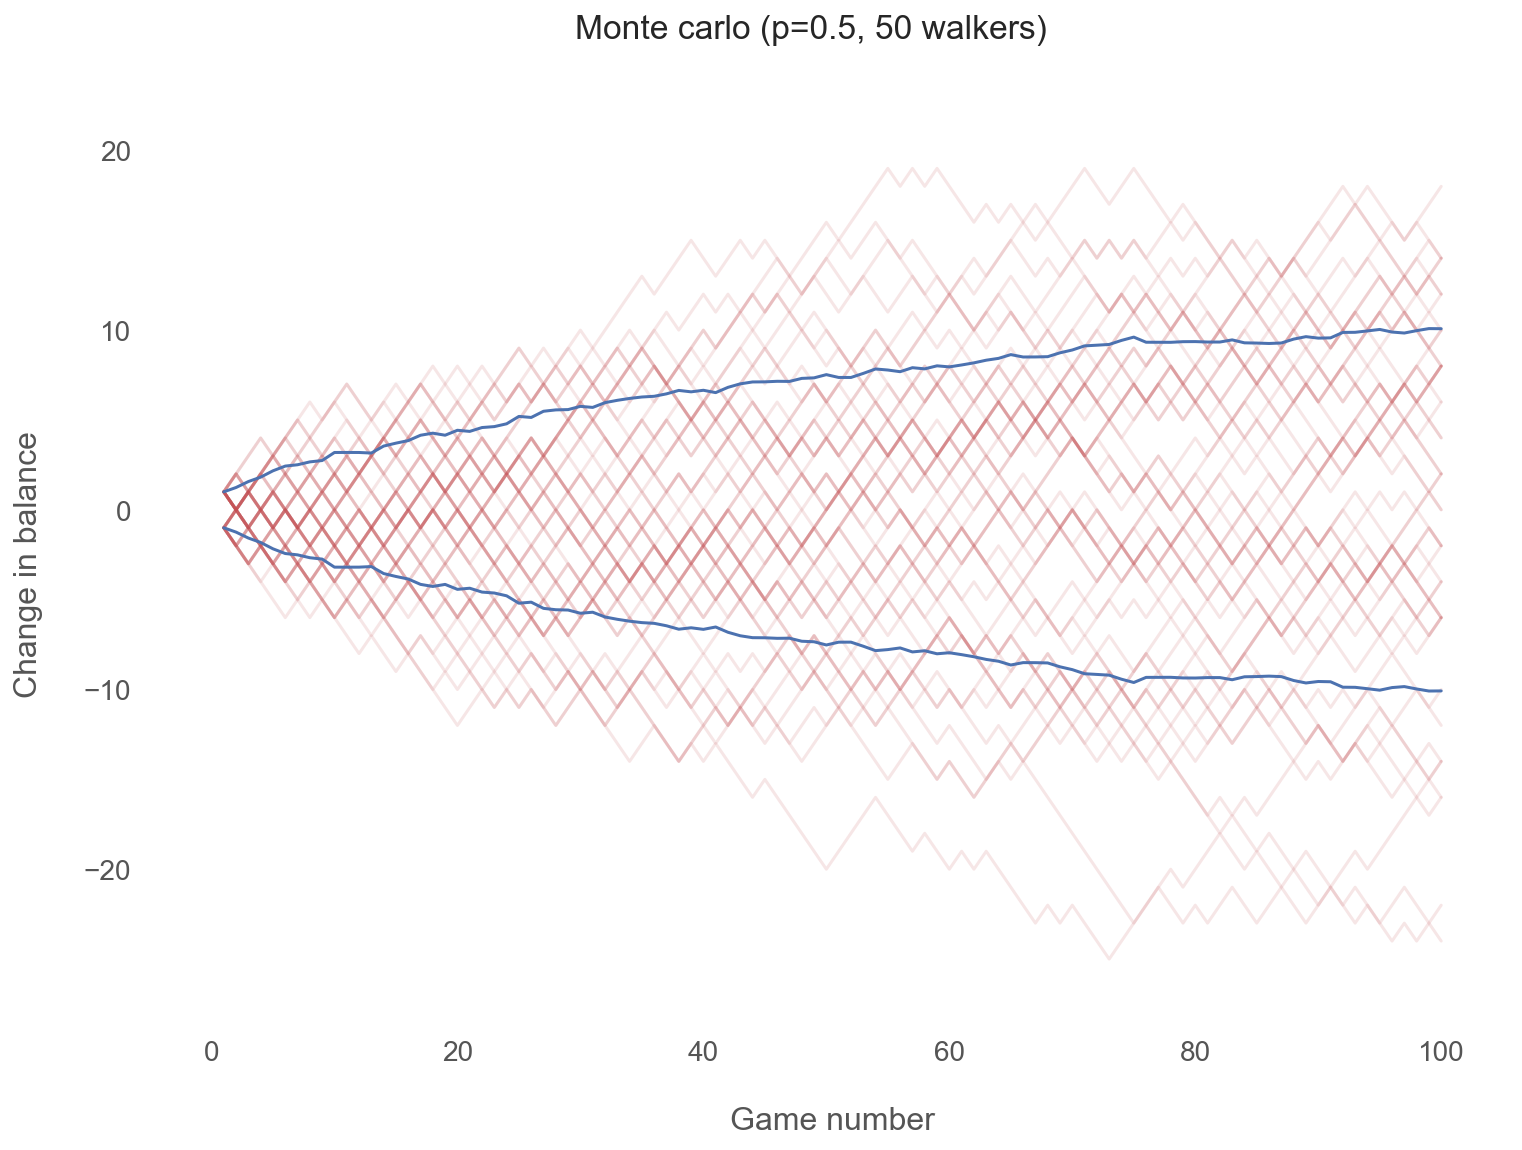

In [92]:
p = 0.5
n_bets = 100
n_walkers = 50

x = np.arange(1, n_bets+1, 1)

y = np.random.binomial(n=1, p=p, size=(n_walkers, n_bets))
y[y == 0] = -1
balances = np.cumsum(y, axis=1)

for balance in tqdm_notebook(balances):
    plt.plot(
        x, balance, color='r', alpha=np.sqrt(1/n_walkers),
    )
    
y_std = np.std(balances, axis=0)

plt.plot(x, y_std, color='b')
plt.plot(x, -y_std, color='b')

plt.ylabel('Change in balance')
plt.xlabel('Game number')
plt.suptitle('Monte carlo (p={:.1f}, {:} walkers)'.format(p, n_walkers))

Text(0.5, 0.98, 'Amount needed to avoid going bust\nMonte carlo (p=0.5, 1000 walkers, $10 bets)')

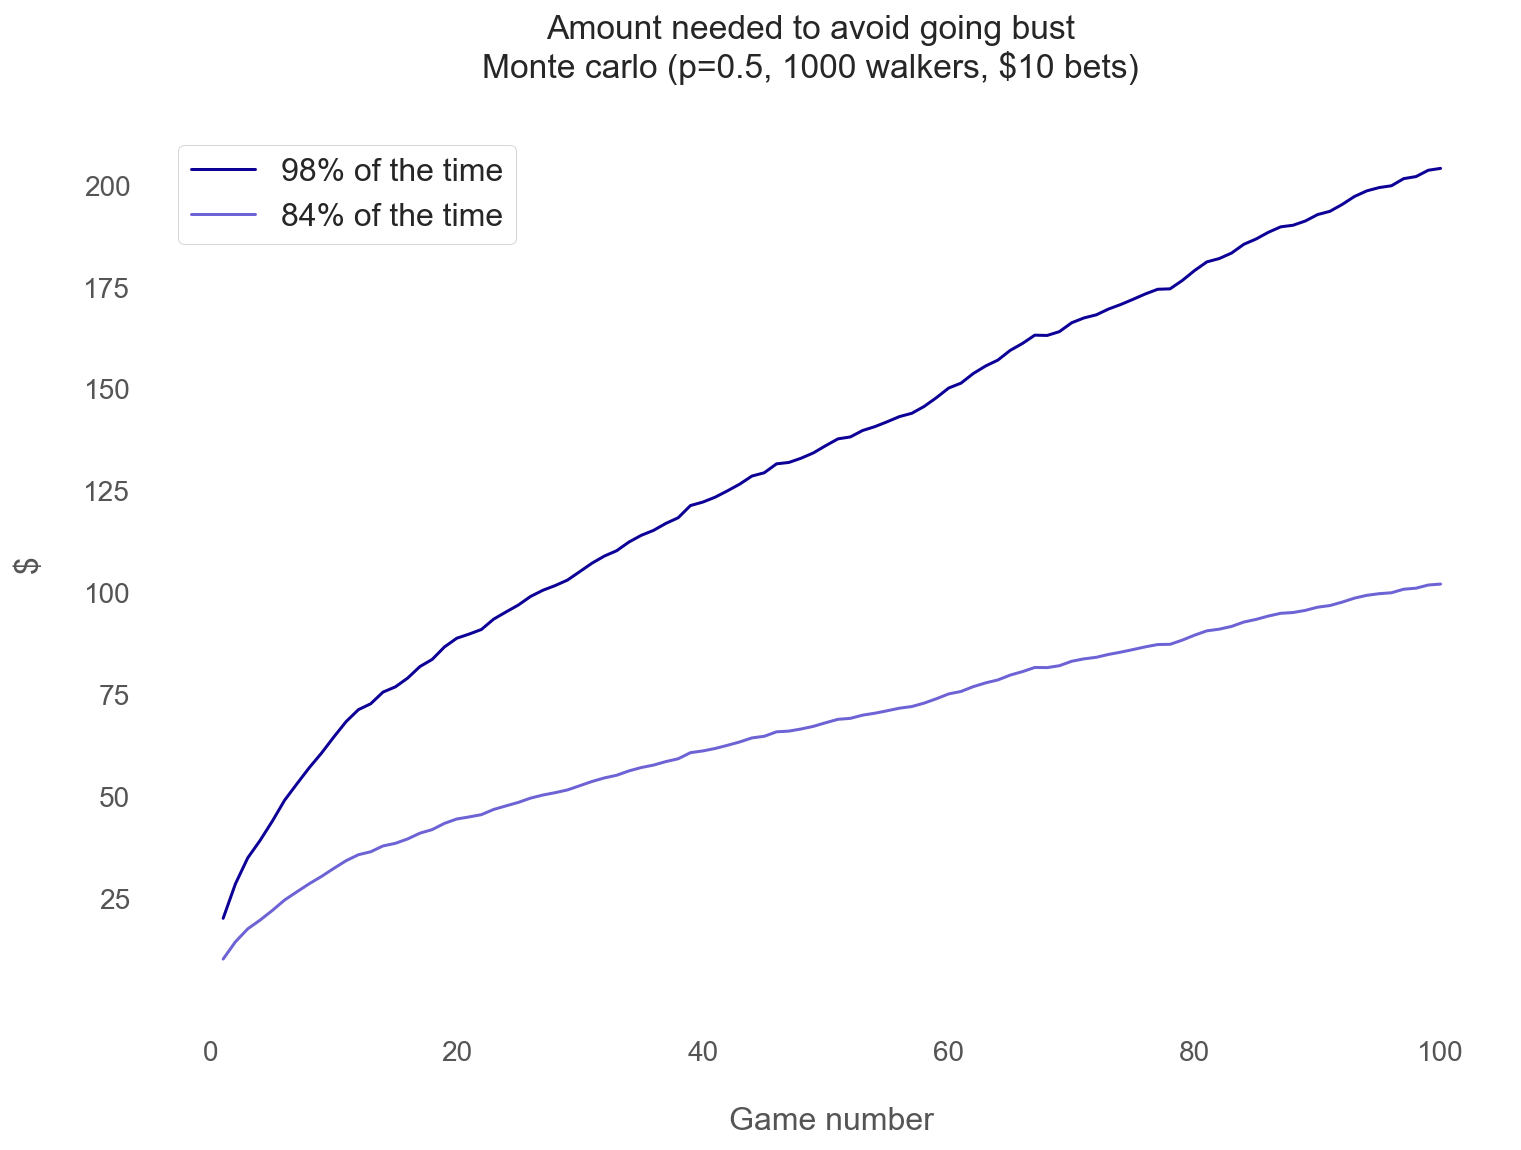

In [102]:
np.random.seed(1)

p = 0.5
n_bets = 100
n_walkers = 1000
bet_amount = 10

x = np.arange(1, n_bets+1, 1)

y = np.random.binomial(n=1, p=p, size=(n_walkers, n_bets))
y[y == 0] = -1
y = y * bet_amount
balances = np.cumsum(y, axis=1)

# for balance in tqdm_notebook(balances):
#     plt.plot(
#         x, balance, color='r', alpha=np.sqrt(1/n_walkers),
#     )

y_std = np.std(balances, axis=0)

plt.plot(x, y_std*2, color='#0d0096', label='98% of the time')
plt.plot(x, y_std, color='#6d63d4', label='84% of the time')

plt.legend()
plt.ylabel('$')
plt.xlabel('Game number')

plt.suptitle('Amount needed to avoid going bust\nMonte carlo (p={:.1f}, {:} walkers, ${:,.0f} bets)'.format(p, n_walkers, bet_amount))



Make into webapp and host on chord